# Generate HuggingFace Dataset

## Imports

In [1]:
import os
import re
import string

import torch
import pandas as pd
import numpy as np
from datasets import Dataset, DatasetDict, load_from_disk

from sentence_transformers import SentenceTransformer
from transformers import DebertaV2Tokenizer, DebertaV2Model
from spellchecker import SpellChecker
import textstat

In [2]:
from readability_scores import readability_scores
from lexical_density import lexical_density as Lexical_Density
from avg_word_sentence_length import average_word_length, average_sentence_length
from introduce_typo import introduce_typo
from TF_IDF import calc_tf_idf
from Add_Periods import Add_Periods

## Load dataset

### Loading prompts train csv

In [3]:
prompts_train = pd.read_csv('./data/prompts_train.csv')
prompts_train

,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


### Loading summaries train csv

In [4]:
summaries_train = pd.read_csv('./data/summaries_train.csv')
summaries_train.head()

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


## Readability Scores

In [5]:
text = """Although the algorithmic approach to readability has been criticized for not taking into account 
         the deeper, more fluid aspects of comprehension, such as motivation, background knowledge, 
         and personal interest, it's a useful tool for getting a general gauge on text's complexity."""

FK_grade, Gunning_Fog, SMOG = readability_scores(text)
print(f"Flesch-Kincaid Grade Level: {FK_grade:.2f}")
print(f"Gunning Fog Index: {Gunning_Fog:.2f}")
print(f"SMOG Index: {SMOG:.2f}")

Flesch-Kincaid Grade Level: 23.13
Gunning Fog Index: 26.50
SMOG Index: 21.19


In [6]:
text = "The quick brown fox jumps over the lazy dog"
noisy_text = introduce_typo(text, probability=0.2)
print(noisy_text)

The qdick brown forx jumhs over the lazjy dog


In [7]:
smog_index = getattr(textstat, 'smog_index')(text)
gunning_fog = getattr(textstat, 'gunning_fog')(text)
coleman_liau_index = getattr(textstat, 'coleman_liau_index')(text)
dale_chall_readability_score = getattr(textstat, 'dale_chall_readability_score')(text)


print(f"dale_chall_readability_score Grade Level: {dale_chall_readability_score:.2f}")
print(f"coleman_liau_index Index: {coleman_liau_index:.2f}")
print(f"gunning_fog Index: {gunning_fog:.2f}")
print(f"smog_index Index: {smog_index:.2f}")

dale_chall_readability_score Grade Level: 5.84
coleman_liau_index Index: 3.51
gunning_fog Index: 3.60
smog_index Index: 0.00


## Lexical density

In [8]:
text = "The cat sat on the mat. The dog sat beside the cat."
print(f"Lexical Density: {Lexical_Density(text)}")

Lexical Density: 0.7142857142857143


## avg_word_sentence_length

In [9]:
text = "Hello world! This is a test. How long is the average sentence? Let's find out."

print(f"Average Word Length: {average_word_length(text):.2f}")
print(f"Average Sentence Length (in words): {average_sentence_length(text):.2f}")

Average Word Length: 5.09
Average Sentence Length (in words): 5.50


## TF-IDF

In [10]:
data1 = {
    'question': ['What is the theme of the text?'],
    'text': ["The short story revolves around a young girl's struggle during the Great Depression."]
}
data2 = {
    'question': ['Where did the event occur?'],
    'text': [ "The documentary narrates events in a small town in Spain during the 1800s."]
}
data3 = {
    'question': ['Who is the main character?'],
    'text': ["The novel centers on the adventures of a sailor named Odysseus."]
}

In [11]:
data={
    'question': prompts_train.loc[0]['prompt_question'],
    'text': prompts_train.loc[0]['prompt_text']
}

In [12]:
data

{'question': 'Summarize at least 3 elements of an ideal tragedy, as described by Aristotle.',
 'text': 'Chapter 13 \r\nAs the sequel to what has already been said, we must proceed to consider what the poet should aim at, and what he should avoid, in constructing his plots; and by what means the specific effect of Tragedy will be produced. \r\nA perfect tragedy should, as we have seen, be arranged not on the simple but on the complex plan. It should, moreover, imitate actions which excite pity and fear, this being the distinctive mark of tragic imitation. It follows plainly, in the first place, that the change of fortune presented must not be the spectacle of a virtuous man brought from prosperity to adversity: for this moves neither pity nor fear; it merely shocks us. Nor, again, that of a bad man passing from adversity to prosperity: for nothing can be more alien to the spirit of Tragedy; it possesses no single tragic quality; it neither satisfies the moral sense nor calls forth pity 

In [13]:
word_score_df = calc_tf_idf(data['question'], data['text'], 10)
word_score_df

['tragedy',
 'tragic',
 'fear',
 'pity',
 'good',
 'like',
 'bad',
 'man',
 'best',
 'stage']

## BM25

In [14]:
class BM25:
    def __init__(self, corpus, k1=1.5, b=0.75):
        self.corpus = corpus
        self.k1 = k1
        self.b = b
        self.doc_lengths = [len(doc.split()) for doc in corpus]
        self.avgdl = sum(self.doc_lengths) / len(corpus)

    def score(self, query, doc):
        """
        Compute BM25 score for a given document and query.
        """
        doc_tokens = doc.split()
        query_tokens = query.split()
        score = 0.0
        
        for token in query_tokens:
            f = doc_tokens.count(token)
            score += (f * (self.k1 + 1)) / (f + self.k1 * (1 - self.b + self.b * len(doc_tokens) / self.avgdl))
            
        return score

    def rank(self, query):
        """
        Rank documents with respect to the given query.
        """
        scores = [(i, self.score(query, doc)) for i, doc in enumerate(self.corpus)]
        return sorted(scores, key=lambda x: x[1], reverse=True)


# Example
corpus = [
    "The cat sat on the mat",
    "The dog sat on the log",
    "Cats and dogs are animals"
]

bm25 = BM25(corpus)
query = "cat on mat"
ranking = bm25.rank(query)
print(ranking)


[(0, 2.922636103151863), (1, 0.9742120343839542), (2, 0.0)]


In [15]:
data['question']

'Summarize at least 3 elements of an ideal tragedy, as described by Aristotle.'

In [16]:
import re

query, text = data['question'], data['text']
# Splitting the provided text into sentences
sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text.replace('\r\n', ' '))
# Applying BM25 to rank sentences
bm25 = BM25(sentences)
ranking = bm25.rank(query)
# Getting top 3 ranked sentence s
top_sentences = [sentences[i[0]] for i in ranking[:3]]

for i, sentence in enumerate(top_sentences, 1):
    print(f"{i}. {sentence}\n")

1. A tragedy, then, to be perfect according to the rules of art, should be of this construction.

2. It should come about as the result not of vice, but of some great error or frailty, in a character either such as we have described, or better rather than worse.

3. It is accounted the best because of the weakness of the spectators; for the poet is guided in what he writes by the wishes of his audience.



**TODO: replace text with BM25 and do BM25 on answere and compare**

In [17]:
prompts_train.loc[0]

prompt_id                                                     39c16e
prompt_question    Summarize at least 3 elements of an ideal trag...
prompt_title                                              On Tragedy
prompt_text        Chapter 13 \r\nAs the sequel to what has alrea...
Name: 0, dtype: object

In [18]:
print(summaries_train.loc[summaries_train['content'] >= 3.9]['text'].item())

As described by Aristotle, three elements of an ideal tragedy would be that the plot should feature the downfall of a man who is not completely evil but who has a flaw which causes his downfall, that it should cause fear and pity in the audience, and that it should have a complex plot, but not a plot with two thread that has two different catastrophes for the good and the bad.  Aristotle  believes that the goal of a tragedy is to "imitate actions which excite pity and fear" and argues that in order for the tragedy to accomplish this goal, it should feature the downfall of a hero "who is neiter eminently good and just, yet whose misfortune is brought on not by vice or depravity, but by some error of judgement or frailty." He thinks that if the hero were purely good, his downfall would simply be shocking to the audience, whereas the downfall of a purely evil man would not arouse pity or fear, since "pity is aroused by unmerited misfortune, fear by the misfortune of a man like ourselves" 

## SpellChecker

In [19]:
def spell_checker_score(text, debug = False):
    def remove_punctuation(st):
        return re.sub(f"[{re.escape(string.punctuation)}]", '', st)
    
    spell = SpellChecker()
    misspelled = spell.unknown(remove_punctuation(text).split())

    if debug:
        for word in misspelled:
            # Get the one `most likely` answer
            print(f"{word} => {spell.correction(word)}")
        
        print(f"misspelled: {len(misspelled)}")
    return len(misspelled)

In [20]:
spell_checker_score(data['text'], True)

wellconstructed => None
alcmaeon => None
telephus => None
reversely => reverse
thyestes => theses
meleager => mileage
aegisthus => None
unmerited => inherited
— => i
misspelled: 9


9

## DebertaV3

In [65]:
class DebertaV3Simple(torch.nn.Module):
    def __init__(self):
        super(DebertaV3Simple, self).__init__()
        # Load the tokenizer and model
        self.tokenizer = DebertaV2Tokenizer.from_pretrained('microsoft/deberta-v3-base')
        self.model = DebertaV2Model.from_pretrained('microsoft/deberta-v3-base')
    

    def encode(self, sentences):
        # Tokenize sentences
        encoded_input = self.tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
        # Compute token embeddings
        with torch.no_grad():
            model_output = self.model(**encoded_input)

        # Only take the embeddings of the [CLS] token (or use the mean of the token embeddings if desired)
        sentence_embeddings = model_output.last_hidden_state[:, 0, :]
        
        return sentence_embeddings

In [67]:
debertaBatch = DebertaV3Simple()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [71]:
text = "Hugging Face is creating a tool that democratizes AI."
embd = debertaBatch.encode([text, text])
print(embd[:, :5], embd.shape)

# prompts_train.loc[0]['prompt_text']

tensor([[ 0.1804,  0.2592,  0.0357, -0.1198,  0.1036],
        [ 0.1804,  0.2592,  0.0357, -0.1198,  0.1036]]) torch.Size([2, 768])


In [72]:
class DebertaV3(torch.nn.Module):
    def __init__(self):
        super(DebertaV3, self).__init__()
        # Load the tokenizer and model
        self.tokenizer = DebertaV2Tokenizer.from_pretrained('microsoft/deberta-v3-base')
        self.model = DebertaV2Model.from_pretrained('microsoft/deberta-v3-base')


    def sliding_window(self, text, window_size=512, overlap_size=256):
        tokenized_text = self.tokenizer(text, return_tensors="pt", truncation=False, padding=False)["input_ids"][0]
        windows = []
        for start_idx in range(0, len(tokenized_text) - window_size + 1, window_size - overlap_size):
            end_idx = start_idx + window_size
            windows.append(tokenized_text[start_idx:end_idx])
        return windows

    def process_windows(self, windows):
        embeddings = []
        for window in windows:
            inputs = {"input_ids": window.unsqueeze(0)}
            outputs = self.model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :]
            embeddings.append(cls_embedding)
        return embeddings
    

    def encode(self, sentences):
        # Tokenize sentences
        encoded_input = self.tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
        # Compute token embeddings
        with torch.no_grad():
            model_output = self.model(**encoded_input)

        if len(encoded_input['input_ids'][0]) > 512:
            windows = self.sliding_window(text)
            window_embeddings = self.process_windows(windows)
            
            # Optionally, you can aggregate the window embeddings to get a single embedding for the entire text
            # For example, by averaging:
            average_embedding = torch.mean(torch.cat(window_embeddings), dim=0)
            return average_embedding
        else:
            # Only take the embeddings of the [CLS] token (or use the mean of the token embeddings if desired)
            sentence_embeddings = model_output.last_hidden_state[:, 0, :]
            
            return sentence_embeddings[0]

In [73]:
deberta = DebertaV3()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [23]:
deberta.tokenizer.special_tokens_map, deberta.tokenizer.sep_token, deberta.tokenizer.sep_token_id

({'bos_token': '[CLS]',
  'eos_token': '[SEP]',
  'unk_token': '[UNK]',
  'sep_token': '[SEP]',
  'pad_token': '[PAD]',
  'cls_token': '[CLS]',
  'mask_token': '[MASK]'},
 '[SEP]',
 2)

In [24]:
text = "Hugging Face is creating a tool that democratizes AI."
text = prompts_train.loc[0]['prompt_text']
embd = deberta.encode(text)
print(embd[:5], embd.shape)

# prompts_train.loc[0]['prompt_text']

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


tensor([ 0.0185,  0.0178, -0.0587,  0.0344, -0.0488], grad_fn=<SliceBackward0>) torch.Size([768])


## Generate HF Dataset

### Load sentence transformers model

In [25]:
# model = SentenceTransformer('all-mpnet-base-v2')
model = deberta

### Preprocess prompts dataset

In [26]:
def preprocess_prompts(prompts_df: pd.DataFrame) -> pd.DataFrame:
    # init an empty new  dataFrame
    new_data = pd.DataFrame({
        'prompt_id': [],
        'embeddings_text': [],
        'tf_idf': [],
        'prompt_question': [],
        'prompt_title': [],
        'tf_idf': []
    })

    for index, row in prompts_df.iterrows():
        # retrieve columns
        prompt_id = row['prompt_id']
        prompt_question = row['prompt_question']
        prompt_title = row['prompt_title']
        prompt_text = row['prompt_text']

        tf_idf = calc_tf_idf(prompt_question, prompt_text, 10)

        # we are creating a batch of the sentences we want to get embeddings
        # sentences = [prompt_question, prompt_text]
        # len_p_question = len(deberta.tokenizer(prompt_question)['input_ids'])
        # len_p_text = len(deberta.tokenizer(prompt_text))
        
        # calling model embedding
        text_embeddings = model.encode(prompt_text).detach().numpy()

        # Create a new row
        new_row = pd.DataFrame({'prompt_id': [prompt_id], 'embeddings_text': [text_embeddings], 'tf_idf': [tf_idf], 'prompt_question': [prompt_question],  'prompt_title': [prompt_title]})
        
        # Append the row
        new_data = pd.concat([new_data.loc[:], new_row], ignore_index=True)

    path = f"./data/preprocessed_data"
    os.makedirs(path, exist_ok=True)
    new_data.to_pickle(f"{path}/prompts_train.pickle")
    return new_data

In [27]:
preprocessed_prompts_train = preprocess_prompts(prompts_train)
preprocessed_prompts_train

,prompt_id,embeddings_text,tf_idf,prompt_question,prompt_title
0,39c16e,"[0.01849878, 0.017825723, -0.058659174, 0.0344...","[tragedy, tragic, fear, pity, good, like, bad,...",Summarize at least 3 elements of an ideal trag...,On Tragedy
1,3b9047,"[0.01849878, 0.017825723, -0.058659174, 0.0344...","[gods, pharaoh, farmers, government, pharaohs,...","In complete sentences, summarize the structure...",Egyptian Social Structure
2,814d6b,"[0.01849878, 0.017825723, -0.058659174, 0.0344...","[students, jones, movement, experiment, class,...",Summarize how the Third Wave developed over su...,The Third Wave
3,ebad26,"[0.01849878, 0.017825723, -0.058659174, 0.0344...","[meat, sausage, hams, spoiled, rats, packers, ...",Summarize the various ways the factory would u...,Excerpt from The Jungle


### Preprocess summaries dataset

In [28]:
def normalize_value(x, min=-2, max=4):
    return 2*((x-min)/(max-min))-1

In [58]:
def preprocess_summaries(summaries_df: pd.DataFrame, prompts_df: pd.DataFrame) -> pd.DataFrame :
    def process_row(index, row):
        print(f"\r{index+1}", end="")
        
        # retrieve columns
        student_id = row["student_id"]
        prompt_id = row["prompt_id"]
        answer = row["text"]
        content = row["content"]
        wording = row["wording"]
        
        # space behind period of end of sentence "Exemple end.Start new sentence text@gmail.com" = "Exemple end. Start new sentence text@gmail.com" 
        cleaned_answer = re.sub(r'(?<=\.)[A-Z]', r' \g<0>', answer)
        cleaned_answer = Add_Periods(cleaned_answer)
        
        # FK_grade, Gunning_Fog, SMOG = readability_scores(text)
        smog_index = getattr(textstat, 'smog_index')(cleaned_answer)
        coleman_liau_index = getattr(textstat, 'coleman_liau_index')(cleaned_answer)
        flesch_reading_ease = getattr(textstat, 'flesch_reading_ease')(cleaned_answer)
        
        lexical_density = Lexical_Density(cleaned_answer)
        spell_checker = spell_checker_score(cleaned_answer)
        
        avg_word_length = average_word_length(cleaned_answer)

        # Retrieving prompt infos
        prompt_row = prompts_df.loc[prompts_df['prompt_id'] == prompt_id]
        
        prompt_tf_idf, prompt_title, prompt_question, embeddings_text = prompt_row['tf_idf'].item(), \
                                                                        prompt_row['prompt_title'].item(), \
                                                                        prompt_row['prompt_question'].item(), \
                                                                        prompt_row['embeddings_text'].item()

        # we are creating a full sentence containing the title, the question and this answer
        sep = model.tokenizer.sep_token
        sentence = prompt_title + sep + prompt_question + sep + answer

        # calling model embedding
        # t_q_a_embeddings = model.encode(sentence).detach().numpy()

        # Calculating tf_idf for prompt question and prompt text in relation with answere text word present in the text
        tf_idf = [word.lower() for word in prompt_tf_idf]
        tf_idf_question = [word.lower() for word in calc_tf_idf(prompt_question, cleaned_answer, 10)]
        
        # Calculate the score representing the number of words from prompt_tf_idf present in answer_tf_idf
        tf_idf_question_score = sum(word in tf_idf_question for word in tf_idf)

        # Create a new row
        return {
            'student_id': student_id,
            'prompt_id': prompt_id,
            'sentence': sentence,
            # 't_q_a_embeddings': t_q_a_embeddings,
            'embeddings_text': embeddings_text,
            'smog_index': smog_index,
            'coleman_liau_index': coleman_liau_index,
            'flesch_reading_ease': flesch_reading_ease,
            'lexical_density': lexical_density,
            'spell_checker': spell_checker,
            'tf_idf_question_score': tf_idf_question_score,
            'avg_word_length': avg_word_length,
            'content': content,
            'wording': wording,
        }
        
    # Use apply to process each row
    # processed_rows = summaries_df.apply(process_row, axis=1)
    processed_rows = summaries_df.apply(lambda x: process_row(x.name, x), axis=1)

    # Convert the list of dictionaries to a DataFrame
    new_data = pd.DataFrame(list(processed_rows))
    
    # # Append the row
    # new_data = pd.concat([new_data.loc[:], new_row], ignore_index=True)

    path = f"./data/preprocessed_data"
    os.makedirs(path, exist_ok=True)
    new_data.to_pickle(f"{path}/summaries_train.pickle") 
    return new_data

In [29]:
def preprocess_summaries(summaries_df: pd.DataFrame, prompts_df: pd.DataFrame) -> pd.DataFrame :
    # init an empty new  dataFrame
    new_data = pd.DataFrame({
        'student_id': [],
        'prompt_id': [],
        't_q_a_embeddings': [],
        'embeddings_text': [],
        'smog_index': [],
        'coleman_liau_index': [],
        'flesch_reading_ease': [],
        'spell_checker': [],
        'tf_idf_question_score': [],
        'lexical_density': [],
        'avg_word_length': [],
        # 'avg_sentence_length': [],
        'content': [],
        'wording': []
    })
    
    for index, row in summaries_df.iterrows():
        print(f"\r{index+1}/{len(summaries_df)}", end="")
        # retrieve columns
        student_id = row["student_id"]
        prompt_id = row["prompt_id"]
        answer = row["text"]
        content = row["content"]
        wording = row["wording"]
        # space behind period of end of sentence "Exemple end.Start new sentence text@gmail.com" = "Exemple end. Start new sentence text@gmail.com" 
        cleaned_answer = re.sub(r'(?<=\.)[A-Z]', r' \g<0>', answer)
        cleaned_answer = Add_Periods(cleaned_answer)
        
        # FK_grade, Gunning_Fog, SMOG = readability_scores(text)
        smog_index = getattr(textstat, 'smog_index')(cleaned_answer)
        coleman_liau_index = getattr(textstat, 'coleman_liau_index')(cleaned_answer)
        flesch_reading_ease = getattr(textstat, 'flesch_reading_ease')(cleaned_answer)
        
        lexical_density = Lexical_Density(cleaned_answer)
        spell_checker = spell_checker_score(cleaned_answer)
        
        avg_word_length = average_word_length(cleaned_answer)

        # Retrieving prompt infos
        prompt_row = prompts_df.loc[prompts_df['prompt_id'] == prompt_id]
        
        prompt_tf_idf, prompt_title, prompt_question, embeddings_text = prompt_row['tf_idf'].item(), \
                                                                        prompt_row['prompt_title'].item(), \
                                                                        prompt_row['prompt_question'].item(), \
                                                                        prompt_row['embeddings_text'].item()

        # we are creating a full sentence containing the title, the question and this answer
        sep = model.tokenizer.sep_token
        sentence = prompt_title + sep + prompt_question + sep + answer

        # calling model embedding
        t_q_a_embeddings = model.encode(sentence).detach().numpy()

        # Calculating tf_idf for prompt question and prompt text in relation with answere text word present in the text
        tf_idf = [word.lower() for word in prompt_tf_idf]
        tf_idf_question = [word.lower() for word in calc_tf_idf(prompt_question, cleaned_answer, 10)]
        
        # Calculate the score representing the number of words from prompt_tf_idf present in answer_tf_idf
        tf_idf_question_score = sum(word in tf_idf_question for word in tf_idf)

        # Create a new row
        new_row = pd.DataFrame({
            'student_id': [student_id],
            'prompt_id': [prompt_id],
            't_q_a_embeddings': [t_q_a_embeddings],
            'embeddings_text': [embeddings_text],
            'smog_index': [smog_index],
            'coleman_liau_index': [coleman_liau_index],
            'flesch_reading_ease': [flesch_reading_ease],
            'lexical_density': [lexical_density],
            'spell_checker': [spell_checker],
            'tf_idf_question_score': [tf_idf_question_score],
            'avg_word_length': [avg_word_length],
            'content': [content],
            'wording': [wording],
        })
        
        # Append the row
        new_data = pd.concat([new_data.loc[:], new_row], ignore_index=True)

    path = f"./data/preprocessed_data"
    os.makedirs(path, exist_ok=True)
    new_data.to_pickle(f"{path}/summaries_train.pickle") 
    return new_data

In [61]:
import time
# Record the start time
start_time = time.time()

preprocess_summaries_train = preprocess_summaries(summaries_train, preprocessed_prompts_train)

# Record the end time
end_time = time.time()

# Compute the difference
execution_time = end_time - start_time

print(f"The function took {execution_time} seconds to execute.")

preprocess_summaries_train

7165The function took 467.4600250720978 seconds to execute.


,student_id,prompt_id,sentence,embeddings_text,smog_index,coleman_liau_index,flesch_reading_ease,lexical_density,spell_checker,tf_idf_question_score,avg_word_length,content,wording
0,000e8c3c7ddb,814d6b,The Third Wave[SEP]Summarize how the Third Wav...,"[0.01849878, 0.017825723, -0.058659174, 0.0344...",10.7,9.04,64.41,0.900000,2,1,5.312500,0.205683,0.380538
1,0020ae56ffbf,ebad26,Excerpt from The Jungle[SEP]Summarize the vari...,"[0.01849878, 0.017825723, -0.058659174, 0.0344...",0.0,4.30,87.39,0.821429,0,1,4.166667,-0.548304,0.506755
2,004e978e639e,3b9047,Egyptian Social Structure[SEP]In complete sent...,"[0.01849878, 0.017825723, -0.058659174, 0.0344...",8.5,9.33,73.58,0.769737,3,1,5.456989,3.128928,4.231226
3,005ab0199905,3b9047,Egyptian Social Structure[SEP]In complete sent...,"[0.01849878, 0.017825723, -0.058659174, 0.0344...",7.8,8.20,87.72,0.888889,3,2,5.636364,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave[SEP]Summarize how the Third Wav...,"[0.01849878, 0.017825723, -0.058659174, 0.0344...",9.9,10.43,66.23,0.789474,11,5,5.712500,3.272894,3.219757
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7160,ff7c7e70df07,ebad26,Excerpt from The Jungle[SEP]Summarize the vari...,"[0.01849878, 0.017825723, -0.058659174, 0.0344...",7.2,3.74,96.38,0.837209,5,2,4.698113,0.205683,0.380538
7161,ffc34d056498,3b9047,Egyptian Social Structure[SEP]In complete sent...,"[0.01849878, 0.017825723, -0.058659174, 0.0344...",3.1,10.43,82.65,0.884615,2,5,6.034483,-0.308448,0.048171
7162,ffd1576d2e1b,3b9047,Egyptian Social Structure[SEP]In complete sent...,"[0.01849878, 0.017825723, -0.058659174, 0.0344...",7.8,8.23,80.92,0.969697,8,1,5.000000,-1.408180,-0.493603
7163,ffe4a98093b2,39c16e,On Tragedy[SEP]Summarize at least 3 elements o...,"[0.01849878, 0.017825723, -0.058659174, 0.0344...",6.0,4.92,90.29,0.777778,1,3,4.627907,-0.393310,0.627128


In [84]:
def process_batch(sentences, model):
    embeddings = model.encode(sentences)
    return embeddings.cpu().numpy()

In [87]:
from tqdm import tqdm

In [88]:
def batch_encode(df, model, batch_size=32):
    # Convert the Series to a list of strings
    sentences_list = df['sentence'].tolist()
    # Initialize an empty list to collect the embeddings
    all_embeddings = []
    # Process sentences in batches
    for i in tqdm(range(0, len(sentences_list), batch_size)):
        batch_sentences = sentences_list[i:i + batch_size]
        batch_embeddings = process_batch(batch_sentences, model)
        all_embeddings.extend(batch_embeddings)
    return all_embeddings

In [89]:
# Encode sentences in batches
embeddings = batch_encode(preprocess_summaries_train, debertaBatch)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 224/224 [1:23:51<00:00, 22.46s/it]


In [91]:
sentences_list[:2]

['The Third Wave[SEP]Summarize how the Third Wave developed over such a short period of time and why the experiment was ended.[SEP]The third wave was an experimentto see how people reacted to a new one leader government. It gained popularity as people wanted to try new things. The students follow anything that is said and start turning on eachother to gain higher power. They had to stop the experement as too many people got to radical with it blindly following there leader',
 'Excerpt from The Jungle[SEP]Summarize the various ways the factory would use or cover up spoiled meat. Cite evidence in your answer.[SEP]They would rub it up with soda to make the smell go away and it wouldnt be a bad smell. Some of the meat would be tossed on the floor where there was sawdust spit of the workers and they would make the meat all over again with the things in it.']

In [92]:
# Add embeddings as a new column to your DataFrame
preprocess_summaries_train['t_q_a_embeddings'] = embeddings
preprocess_summaries_train['normalized_lexical_density'] = normalize_value(preprocess_summaries_train['lexical_density'], min=0, max=1)
preprocess_summaries_train['normalized_spell_checker'] = normalize_value(preprocess_summaries_train['spell_checker'], min=0, max=10)
preprocess_summaries_train['normalized_tf_idf_question_score'] = normalize_value(preprocess_summaries_train['tf_idf_question_score'], min=0, max=10)
preprocess_summaries_train['normalized_avg_word_length'] = normalize_value(preprocess_summaries_train['avg_word_length'], min=3, max=10)
preprocess_summaries_train['normalized_smog_index'] = normalize_value(preprocess_summaries_train['smog_index'], min=0, max=17)
preprocess_summaries_train['normalized_coleman_liau_index'] = normalize_value(preprocess_summaries_train['coleman_liau_index'], min=0, max=17)
preprocess_summaries_train['normalized_flesch_reading_ease'] = normalize_value(preprocess_summaries_train['flesch_reading_ease'], min=1, max=100)
preprocess_summaries_train['normalized_content'] = normalize_value(preprocess_summaries_train['content'])
preprocess_summaries_train['normalized_wording'] = normalize_value(preprocess_summaries_train['wording'])
preprocess_summaries_train

,student_id,prompt_id,sentence,embeddings_text,smog_index,coleman_liau_index,flesch_reading_ease,lexical_density,spell_checker,tf_idf_question_score,...,t_q_a_embeddings,normalized_lexical_density,normalized_spell_checker,normalized_tf_idf_question_score,normalized_avg_word_length,normalized_smog_index,normalized_coleman_liau_index,normalized_flesch_reading_ease,normalized_content,normalized_wording
0,000e8c3c7ddb,814d6b,The Third Wave[SEP]Summarize how the Third Wav...,"[0.01849878, 0.017825723, -0.058659174, 0.0344...",10.7,9.04,64.41,0.900000,2,1,...,"[0.13540374, 0.2083462, -0.034828812, -0.09986...",0.800000,-0.6,-0.8,-0.339286,0.258824,0.063529,0.281010,-0.264772,-0.206487
1,0020ae56ffbf,ebad26,Excerpt from The Jungle[SEP]Summarize the vari...,"[0.01849878, 0.017825723, -0.058659174, 0.0344...",0.0,4.30,87.39,0.821429,0,1,...,"[0.16683473, 0.22628784, 0.020921046, -0.08685...",0.642857,-1.0,-0.8,-0.666667,-1.000000,-0.494118,0.745253,-0.516101,-0.164415
2,004e978e639e,3b9047,Egyptian Social Structure[SEP]In complete sent...,"[0.01849878, 0.017825723, -0.058659174, 0.0344...",8.5,9.33,73.58,0.769737,3,1,...,"[0.09858, 0.16076183, 0.054611303, -0.06561435...",0.539474,-0.4,-0.8,-0.298003,0.000000,0.097647,0.466263,0.709643,1.077075
3,005ab0199905,3b9047,Egyptian Social Structure[SEP]In complete sent...,"[0.01849878, 0.017825723, -0.058659174, 0.0344...",7.8,8.20,87.72,0.888889,3,2,...,"[0.1928322, 0.21980517, 0.008302653, -0.092606...",0.777778,-0.4,-0.6,-0.246753,-0.082353,-0.035294,0.751919,-0.403538,-0.490472
4,0070c9e7af47,814d6b,The Third Wave[SEP]Summarize how the Third Wav...,"[0.01849878, 0.017825723, -0.058659174, 0.0344...",9.9,10.43,66.23,0.789474,11,5,...,"[0.07992613, 0.16987555, 0.026804775, -0.05297...",0.578947,1.2,0.0,-0.225000,0.164706,0.227059,0.317778,0.757631,0.739919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7160,ff7c7e70df07,ebad26,Excerpt from The Jungle[SEP]Summarize the vari...,"[0.01849878, 0.017825723, -0.058659174, 0.0344...",7.2,3.74,96.38,0.837209,5,2,...,"[0.16507122, 0.23010147, 0.027471375, -0.07913...",0.674419,0.0,-0.6,-0.514825,-0.152941,-0.560000,0.926869,-0.264772,-0.206487
7161,ffc34d056498,3b9047,Egyptian Social Structure[SEP]In complete sent...,"[0.01849878, 0.017825723, -0.058659174, 0.0344...",3.1,10.43,82.65,0.884615,2,5,...,"[0.16980532, 0.23310205, 0.004245162, -0.11082...",0.769231,-0.6,0.0,-0.133005,-0.635294,0.227059,0.649495,-0.436149,-0.317276
7162,ffd1576d2e1b,3b9047,Egyptian Social Structure[SEP]In complete sent...,"[0.01849878, 0.017825723, -0.058659174, 0.0344...",7.8,8.23,80.92,0.969697,8,1,...,"[0.16936217, 0.23814769, 0.026855765, -0.09064...",0.939394,0.6,-0.8,-0.428571,-0.082353,-0.031765,0.614545,-0.802727,-0.497868
7163,ffe4a98093b2,39c16e,On Tragedy[SEP]Summarize at least 3 elements o...,"[0.01849878, 0.017825723, -0.058659174, 0.0344...",6.0,4.92,90.29,0.777778,1,3,...,"[0.1540325, 0.23656614, 0.019153811, -0.103998...",0.555556,-0.8,-0.4,-0.534884,-0.294118,-0.421176,0.803838,-0.464437,-0.124291


### Saving data:

In [93]:
path = f"./data/preprocessed_data"
os.makedirs(path, exist_ok=True)
preprocess_summaries_train.to_pickle(f"{path}/summaries_train.pickle")

In [94]:
print("smog_index: ", preprocess_summaries_train['smog_index'].min(), preprocess_summaries_train['smog_index'].max())
print("coleman_liau_index: ", preprocess_summaries_train['coleman_liau_index'].min(), preprocess_summaries_train['coleman_liau_index'].max())
print("flesch_reading_ease: ", preprocess_summaries_train['flesch_reading_ease'].min(), preprocess_summaries_train['flesch_reading_ease'].max())
print("lexical_density: ", preprocess_summaries_train['lexical_density'].min(), preprocess_summaries_train['lexical_density'].max())
print("spell_checker: ", preprocess_summaries_train['spell_checker'].min(), preprocess_summaries_train['spell_checker'].max())
print("tf_idf_question_score: ", preprocess_summaries_train['tf_idf_question_score'].min(), preprocess_summaries_train['tf_idf_question_score'].max())
print("avg_word_length: ", preprocess_summaries_train['avg_word_length'].min(), preprocess_summaries_train['avg_word_length'].max())


smog_index:  0.0 16.9
coleman_liau_index:  -0.28 18.72
flesch_reading_ease:  6.18 110.77
lexical_density:  0.3508771929824561 1.0
spell_checker:  0 30
tf_idf_question_score:  0 8
avg_word_length:  3.5 7.7727272727272725


-----

## Correlation

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [96]:
preprocess_summaries_train

,student_id,prompt_id,sentence,embeddings_text,smog_index,coleman_liau_index,flesch_reading_ease,lexical_density,spell_checker,tf_idf_question_score,...,t_q_a_embeddings,normalized_lexical_density,normalized_spell_checker,normalized_tf_idf_question_score,normalized_avg_word_length,normalized_smog_index,normalized_coleman_liau_index,normalized_flesch_reading_ease,normalized_content,normalized_wording
0,000e8c3c7ddb,814d6b,The Third Wave[SEP]Summarize how the Third Wav...,"[0.01849878, 0.017825723, -0.058659174, 0.0344...",10.7,9.04,64.41,0.900000,2,1,...,"[0.13540374, 0.2083462, -0.034828812, -0.09986...",0.800000,-0.6,-0.8,-0.339286,0.258824,0.063529,0.281010,-0.264772,-0.206487
1,0020ae56ffbf,ebad26,Excerpt from The Jungle[SEP]Summarize the vari...,"[0.01849878, 0.017825723, -0.058659174, 0.0344...",0.0,4.30,87.39,0.821429,0,1,...,"[0.16683473, 0.22628784, 0.020921046, -0.08685...",0.642857,-1.0,-0.8,-0.666667,-1.000000,-0.494118,0.745253,-0.516101,-0.164415
2,004e978e639e,3b9047,Egyptian Social Structure[SEP]In complete sent...,"[0.01849878, 0.017825723, -0.058659174, 0.0344...",8.5,9.33,73.58,0.769737,3,1,...,"[0.09858, 0.16076183, 0.054611303, -0.06561435...",0.539474,-0.4,-0.8,-0.298003,0.000000,0.097647,0.466263,0.709643,1.077075
3,005ab0199905,3b9047,Egyptian Social Structure[SEP]In complete sent...,"[0.01849878, 0.017825723, -0.058659174, 0.0344...",7.8,8.20,87.72,0.888889,3,2,...,"[0.1928322, 0.21980517, 0.008302653, -0.092606...",0.777778,-0.4,-0.6,-0.246753,-0.082353,-0.035294,0.751919,-0.403538,-0.490472
4,0070c9e7af47,814d6b,The Third Wave[SEP]Summarize how the Third Wav...,"[0.01849878, 0.017825723, -0.058659174, 0.0344...",9.9,10.43,66.23,0.789474,11,5,...,"[0.07992613, 0.16987555, 0.026804775, -0.05297...",0.578947,1.2,0.0,-0.225000,0.164706,0.227059,0.317778,0.757631,0.739919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7160,ff7c7e70df07,ebad26,Excerpt from The Jungle[SEP]Summarize the vari...,"[0.01849878, 0.017825723, -0.058659174, 0.0344...",7.2,3.74,96.38,0.837209,5,2,...,"[0.16507122, 0.23010147, 0.027471375, -0.07913...",0.674419,0.0,-0.6,-0.514825,-0.152941,-0.560000,0.926869,-0.264772,-0.206487
7161,ffc34d056498,3b9047,Egyptian Social Structure[SEP]In complete sent...,"[0.01849878, 0.017825723, -0.058659174, 0.0344...",3.1,10.43,82.65,0.884615,2,5,...,"[0.16980532, 0.23310205, 0.004245162, -0.11082...",0.769231,-0.6,0.0,-0.133005,-0.635294,0.227059,0.649495,-0.436149,-0.317276
7162,ffd1576d2e1b,3b9047,Egyptian Social Structure[SEP]In complete sent...,"[0.01849878, 0.017825723, -0.058659174, 0.0344...",7.8,8.23,80.92,0.969697,8,1,...,"[0.16936217, 0.23814769, 0.026855765, -0.09064...",0.939394,0.6,-0.8,-0.428571,-0.082353,-0.031765,0.614545,-0.802727,-0.497868
7163,ffe4a98093b2,39c16e,On Tragedy[SEP]Summarize at least 3 elements o...,"[0.01849878, 0.017825723, -0.058659174, 0.0344...",6.0,4.92,90.29,0.777778,1,3,...,"[0.1540325, 0.23656614, 0.019153811, -0.103998...",0.555556,-0.8,-0.4,-0.534884,-0.294118,-0.421176,0.803838,-0.464437,-0.124291


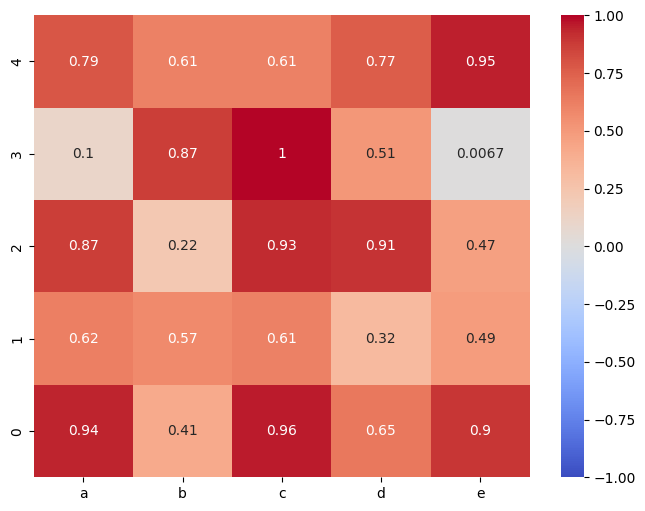

In [97]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create a sample dataframe
data = pd.DataFrame(np.random.random((5, 5)), columns=["a", "b", "c", "d", "e"])

# Plot the heatmap with annotations
plt.figure(figsize=(8, 6))
sns.heatmap(data, annot=True, cmap="coolwarm", vmin=-1, vmax=1)

# Adjust the y-axis limits
plt.ylim(0, len(data))

# Show the plot
plt.show()

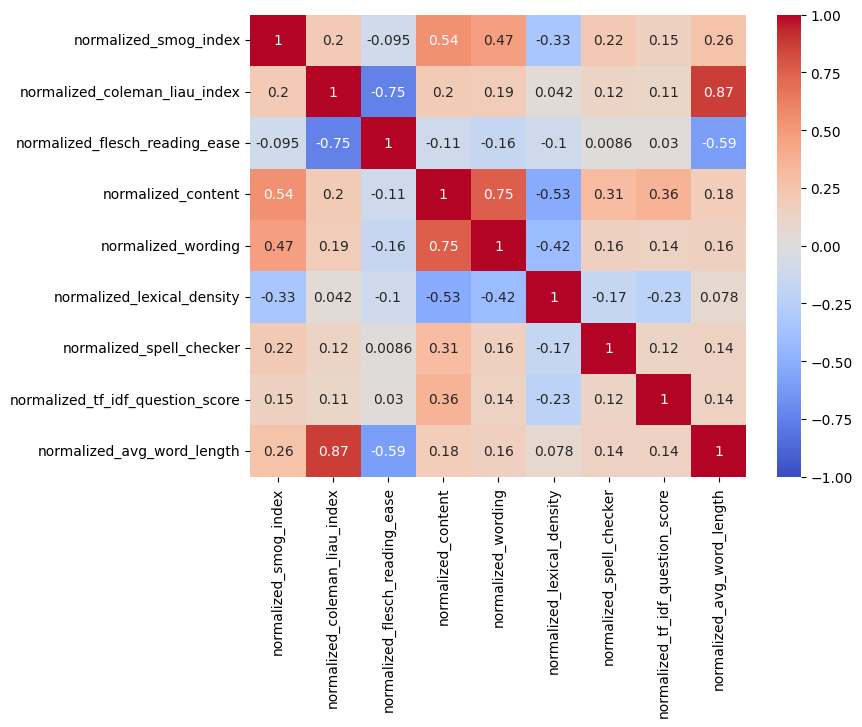

In [98]:
corr_df = preprocess_summaries_train[[
    'normalized_smog_index',
    'normalized_coleman_liau_index',
    'normalized_flesch_reading_ease',
    'normalized_content',
    'normalized_wording',
    'normalized_lexical_density',
    'normalized_spell_checker',
    'normalized_tf_idf_question_score',
    'normalized_avg_word_length',
    # 'normalized_avg_sentence_length',
]]
# Compute the correlation matrix
correlation_matrix = corr_df.corr()
# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)

# Show the plot
plt.show()

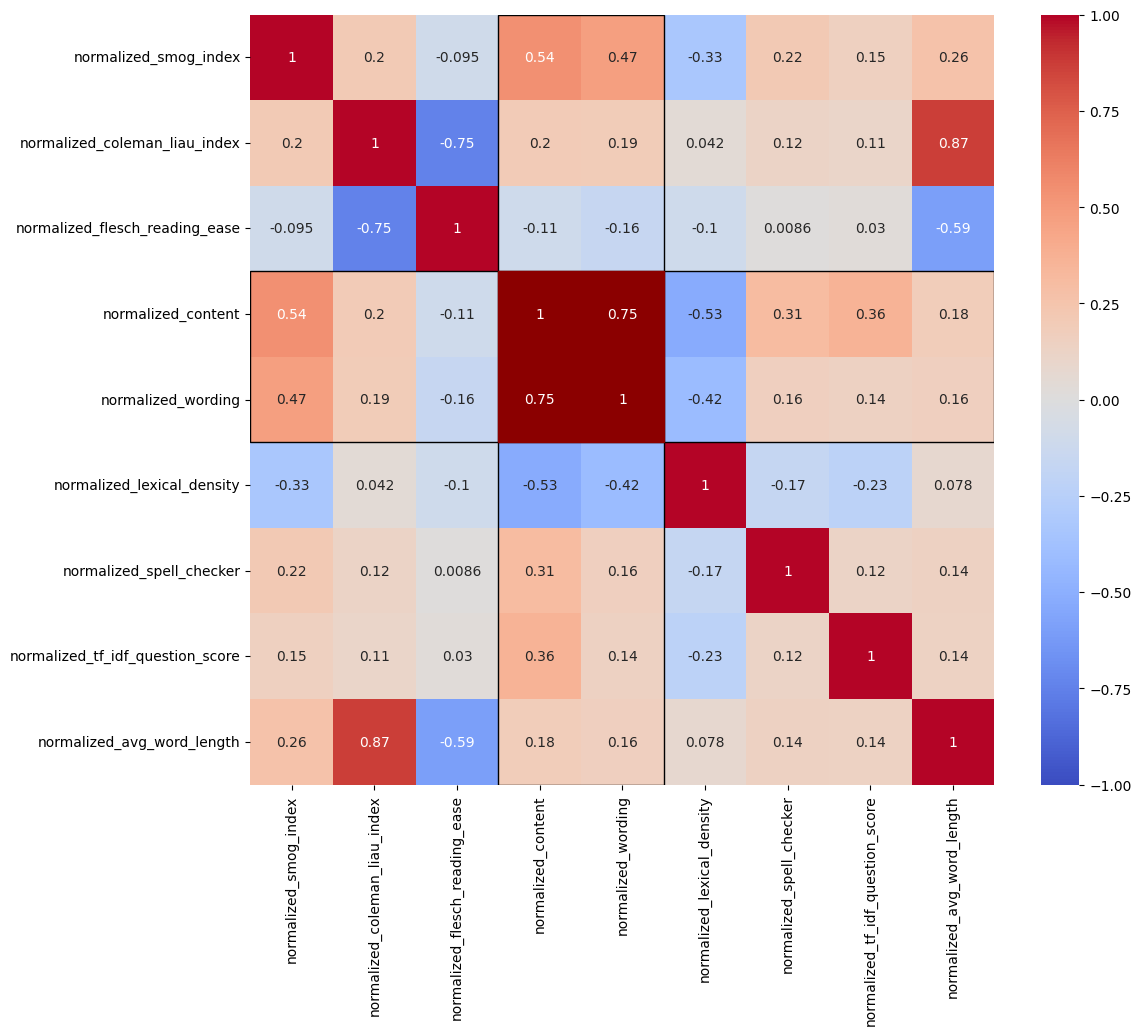

In [99]:

# Identify the indices of 'content' and 'wording'
content_index = corr_df.columns.get_loc('normalized_content')
wording_index = corr_df.columns.get_loc('normalized_wording')

# Compute the correlation matrix
correlation_matrix = corr_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)

position = 0

# Add borders around 'content' and 'wording' rows and columns
plt.gca().add_patch(plt.Rectangle((content_index-position, 0), 2, correlation_matrix.shape[0], fill=False, edgecolor='black', lw=1))
plt.gca().add_patch(plt.Rectangle((0, content_index), correlation_matrix.shape[1], 2, fill=False, edgecolor='black', lw=1))
# plt.gca().add_patch(plt.Rectangle((wording_index, 0), 1, correlation_matrix.shape[0], fill=False, edgecolor='darkred', lw=1))
# plt.gca().add_patch(plt.Rectangle((0, wording_index), correlation_matrix.shape[1], 1, fill=False, edgecolor='darkred', lw=1))
plt.gca().add_patch(plt.Rectangle((content_index, content_index), 2, 2, fill=True, facecolor='darkred', edgecolor='darkred', lw=1))

# Show the plot
plt.show()

In [100]:
correlation_matrix.to_json('corr.json')

In [101]:
# assert "a" == "b", "Stop"

In [102]:
preprocess_summaries_train = pd.read_pickle("./data/preprocessed_data/summaries_train.pickle")

In [103]:
preprocess_summaries_train

,student_id,prompt_id,sentence,embeddings_text,smog_index,coleman_liau_index,flesch_reading_ease,lexical_density,spell_checker,tf_idf_question_score,...,t_q_a_embeddings,normalized_lexical_density,normalized_spell_checker,normalized_tf_idf_question_score,normalized_avg_word_length,normalized_smog_index,normalized_coleman_liau_index,normalized_flesch_reading_ease,normalized_content,normalized_wording
0,000e8c3c7ddb,814d6b,The Third Wave[SEP]Summarize how the Third Wav...,"[0.01849878, 0.017825723, -0.058659174, 0.0344...",10.7,9.04,64.41,0.900000,2,1,...,"[0.13540374, 0.2083462, -0.034828812, -0.09986...",0.800000,-0.6,-0.8,-0.339286,0.258824,0.063529,0.281010,-0.264772,-0.206487
1,0020ae56ffbf,ebad26,Excerpt from The Jungle[SEP]Summarize the vari...,"[0.01849878, 0.017825723, -0.058659174, 0.0344...",0.0,4.30,87.39,0.821429,0,1,...,"[0.16683473, 0.22628784, 0.020921046, -0.08685...",0.642857,-1.0,-0.8,-0.666667,-1.000000,-0.494118,0.745253,-0.516101,-0.164415
2,004e978e639e,3b9047,Egyptian Social Structure[SEP]In complete sent...,"[0.01849878, 0.017825723, -0.058659174, 0.0344...",8.5,9.33,73.58,0.769737,3,1,...,"[0.09858, 0.16076183, 0.054611303, -0.06561435...",0.539474,-0.4,-0.8,-0.298003,0.000000,0.097647,0.466263,0.709643,1.077075
3,005ab0199905,3b9047,Egyptian Social Structure[SEP]In complete sent...,"[0.01849878, 0.017825723, -0.058659174, 0.0344...",7.8,8.20,87.72,0.888889,3,2,...,"[0.1928322, 0.21980517, 0.008302653, -0.092606...",0.777778,-0.4,-0.6,-0.246753,-0.082353,-0.035294,0.751919,-0.403538,-0.490472
4,0070c9e7af47,814d6b,The Third Wave[SEP]Summarize how the Third Wav...,"[0.01849878, 0.017825723, -0.058659174, 0.0344...",9.9,10.43,66.23,0.789474,11,5,...,"[0.07992613, 0.16987555, 0.026804775, -0.05297...",0.578947,1.2,0.0,-0.225000,0.164706,0.227059,0.317778,0.757631,0.739919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7160,ff7c7e70df07,ebad26,Excerpt from The Jungle[SEP]Summarize the vari...,"[0.01849878, 0.017825723, -0.058659174, 0.0344...",7.2,3.74,96.38,0.837209,5,2,...,"[0.16507122, 0.23010147, 0.027471375, -0.07913...",0.674419,0.0,-0.6,-0.514825,-0.152941,-0.560000,0.926869,-0.264772,-0.206487
7161,ffc34d056498,3b9047,Egyptian Social Structure[SEP]In complete sent...,"[0.01849878, 0.017825723, -0.058659174, 0.0344...",3.1,10.43,82.65,0.884615,2,5,...,"[0.16980532, 0.23310205, 0.004245162, -0.11082...",0.769231,-0.6,0.0,-0.133005,-0.635294,0.227059,0.649495,-0.436149,-0.317276
7162,ffd1576d2e1b,3b9047,Egyptian Social Structure[SEP]In complete sent...,"[0.01849878, 0.017825723, -0.058659174, 0.0344...",7.8,8.23,80.92,0.969697,8,1,...,"[0.16936217, 0.23814769, 0.026855765, -0.09064...",0.939394,0.6,-0.8,-0.428571,-0.082353,-0.031765,0.614545,-0.802727,-0.497868
7163,ffe4a98093b2,39c16e,On Tragedy[SEP]Summarize at least 3 elements o...,"[0.01849878, 0.017825723, -0.058659174, 0.0344...",6.0,4.92,90.29,0.777778,1,3,...,"[0.1540325, 0.23656614, 0.019153811, -0.103998...",0.555556,-0.8,-0.4,-0.534884,-0.294118,-0.421176,0.803838,-0.464437,-0.124291


### Serialize and deserialize functions

In [104]:
def serialize_array(arr):
    return arr.tobytes()
    
def deserialize_array(binary_string, dtype, shape):
    return np.frombuffer(binary_string, dtype=dtype).reshape(shape)

In [105]:
def preprocess_data(data):
    data['t_q_a_embeddings'] = data['t_q_a_embeddings'].apply(serialize_array)
    data['embeddings_text'] = data['embeddings_text'].apply(serialize_array)
    return data

In [106]:
preprocess_summaries_train = preprocess_data(preprocess_summaries_train)

### Converting the pandas dataset to huggingFace dataset

In [107]:
train_dataset = Dataset.from_pandas(preprocess_summaries_train)

In [108]:
dataset = {
    'train': train_dataset,
}

In [110]:
dataset = DatasetDict(dataset)
path = './data/hugging_face/'
os.makedirs(path, exist_ok=True)
dataset.save_to_disk(path)

Saving the dataset (0/1 shards):   0%|          | 0/7165 [00:00<?, ? examples/s]

### Test the HF dataset

In [111]:
# Later you can load the entire DatasetDict back from disk like this
dataset_dict = DatasetDict.load_from_disk(path)

In [113]:
print(dataset_dict)
print()
print(deserialize_array(dataset_dict['train'][0]['t_q_a_embeddings'], np.float32, (768)).shape)
print()
print(deserialize_array(dataset_dict['train'][0]['embeddings_text'], np.float32, (768)).shape)
print()
print(dataset_dict['train'][0]['content'])
print()
print(dataset_dict['train'][0]['normalized_content'])

DatasetDict({
    train: Dataset({
        features: ['student_id', 'prompt_id', 'sentence', 'embeddings_text', 'smog_index', 'coleman_liau_index', 'flesch_reading_ease', 'lexical_density', 'spell_checker', 'tf_idf_question_score', 'avg_word_length', 'content', 'wording', 't_q_a_embeddings', 'normalized_lexical_density', 'normalized_spell_checker', 'normalized_tf_idf_question_score', 'normalized_avg_word_length', 'normalized_smog_index', 'normalized_coleman_liau_index', 'normalized_flesch_reading_ease', 'normalized_content', 'normalized_wording'],
        num_rows: 7165
    })
})

(768,)

(768,)

0.205682506482641

-0.2647724978391196


In [114]:
dataset_dict['train'].features

{'student_id': Value(dtype='string', id=None),
 'prompt_id': Value(dtype='string', id=None),
 'sentence': Value(dtype='string', id=None),
 'embeddings_text': Value(dtype='binary', id=None),
 'smog_index': Value(dtype='float64', id=None),
 'coleman_liau_index': Value(dtype='float64', id=None),
 'flesch_reading_ease': Value(dtype='float64', id=None),
 'lexical_density': Value(dtype='float64', id=None),
 'spell_checker': Value(dtype='int64', id=None),
 'tf_idf_question_score': Value(dtype='int64', id=None),
 'avg_word_length': Value(dtype='float64', id=None),
 'content': Value(dtype='float64', id=None),
 'wording': Value(dtype='float64', id=None),
 't_q_a_embeddings': Value(dtype='binary', id=None),
 'normalized_lexical_density': Value(dtype='float64', id=None),
 'normalized_spell_checker': Value(dtype='float64', id=None),
 'normalized_tf_idf_question_score': Value(dtype='float64', id=None),
 'normalized_avg_word_length': Value(dtype='float64', id=None),
 'normalized_smog_index': Value(dt